In [1]:
import os 
import sys 
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

In [2]:
import torch 
import pandas as pd 
from data_preparation import *
from tensorconversion import *
from dataloader import *
from torch.utils.data import DataLoader
import torch.optim as optim

In [3]:
model1= torch.load("Models/Muta_MLP_best_model.pth")

/tmp/ipykernel_7784/1392335516.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1= torch.load("Models/Muta_MLP_best_model.pth")


In [4]:
from torchinfo import summary
summary(model1)

Layer (type:depth-idx)                   Param #
CombinedModelGATMLP                      --
├─GATModel: 1-1                          --
│    └─GATConv: 2-1                      171
│    │    └─SumAggregation: 3-1          --
│    │    └─Linear: 3-2                  513
│    └─Linear: 2-2                       1,972
├─MLPModel: 1-2                          --
│    └─Sequential: 2-3                   --
│    │    └─Linear: 3-3                  10,115,493
│    │    └─BatchNorm1d: 3-4             4,938
│    │    └─ReLU: 3-5                    --
│    │    └─Dropout: 3-6                 --
│    │    └─Linear: 3-7                  456,950
├─Linear: 1-3                            24,640
├─BatchNorm1d: 1-4                       224
├─Dropout: 1-5                           --
├─Linear: 1-6                            113
Total params: 10,605,014
Trainable params: 10,605,014
Non-trainable params: 0

In [5]:
test_df = pd.read_excel('Data/inference.xlsx')

In [6]:
len(test_df)

7

In [7]:
# test_df = test_df.iloc[[4]]

In [8]:
test_df.head()

,Smiles,label
0,Clc1cc(ccc1N=Nc1c(O)ccc2c1cccc2)[N+](=O)[O-],1
1,Oc2ccc1ccccc1c2/N=N/c3ccccc3Cl,1
2,O=N(=O)c3ccc(/N=N/c1c(O)ccc2ccccc12)cc3,1
3,Oc2ccc1ccccc1c2/N=N/c3ccccc3,1
4,O=C(O)c3cc1ccccc1c(/N=N/c2ccccc2)c3O,1


In [9]:
test_df = test_df.reset_index()

In [10]:
test_df.columns

Index(['index', 'Smiles', 'label'], dtype='object')

In [11]:
def preprocess(smiles,labels=None,batch_size=None,shuffle=None,generator=None):
    processor = MoleculeProcessor(smiles,labels)
    full_graph_batch = processor.node_edge_feature_extraction()
    fps = np.array(processor.calculate_fingerprint(radius=3,fpsize=4096))
    tensor_converter = TensorConversion()
    # fps_data = tensor_converter.reshape_fingerprints_array_convert_to_tensor(fps)
    fps_data = tensor_converter.convert_to_tensor(fps)
    combined_dataset = SynchronizedDataset(full_graph_batch,fps_data)
    combined_dataloader = DataLoader(
    combined_dataset, 
    batch_size = batch_size,
    shuffle = shuffle,
    generator = generator, 
    collate_fn=collate_fn
    # generator=torch.Generator().manual_seed(42)
)
    return combined_dataloader

In [12]:
test_dataloader = preprocess(test_df['Smiles'],test_df['label'],batch_size=64)

2026-01-30 11:28:09 - data_preparation.py:45 - _generate_molecules - Total valid SMILES found: 7
2026-01-30 11:28:09 - tensorconversion.py:24 - convert_to_tensor - Converting fingerprint array to tensor. Shape: (7, 4096)
2026-01-30 11:28:09 - tensorconversion.py:26 - convert_to_tensor - Converted tensor shape: torch.Size([7, 4096])


In [13]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
import io
import numpy as np
import matplotlib.colors as mcolors
import torch

def create_custom_colormap(predicted_label, threshold=0.4):
    light_red = np.array([0.8, 0.2, 0.2])  # Light red
    light_green = np.array([0.2, 0.8, 0.2])  # Light green
    
    if predicted_label == 0:
        colors = [light_red, light_green]
    else:
        colors = [light_green, light_red]

    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
    
    return cmap

def visualize_attention(smiles, attention_scores, predicted_label, actual_label):
    mol = Chem.MolFromSmiles(smiles)
    drawer = Draw.MolDraw2DCairo(400, 400)
    options = drawer.drawOptions()

    num_atoms = len(mol.GetAtoms())
    num_bonds = len(mol.GetBonds())    

    bond_attention_scores = attention_scores[:num_bonds]
    atom_attention_scores = attention_scores[num_bonds:num_bonds + num_atoms]

    atom_cmap = create_custom_colormap(predicted_label)
    bond_cmap = create_custom_colormap(predicted_label)

    atom_norm = plt.Normalize(vmin=min(atom_attention_scores), vmax=max(atom_attention_scores))
    atom_colors = [atom_cmap(atom_norm(score)) for score in atom_attention_scores]
    atom_color_dict = {atom.GetIdx(): atom_colors[idx] for idx, atom in enumerate(mol.GetAtoms())}

    bond_norm = plt.Normalize(vmin=min(bond_attention_scores), vmax=max(bond_attention_scores))
    bond_colors = [bond_cmap(bond_norm(score)) for score in bond_attention_scores]
    bond_color_dict = {bond.GetIdx(): bond_colors[idx] for idx, bond in enumerate(mol.GetBonds())}

    drawer.DrawMolecule(
        mol,
        highlightAtoms=[atom.GetIdx() for atom in mol.GetAtoms()],
        highlightAtomColors=atom_color_dict,
        highlightBonds=[bond.GetIdx() for bond in mol.GetBonds()],
        highlightBondColors=bond_color_dict
    )
    drawer.FinishDrawing()

    img = drawer.GetDrawingText()
    fig, ax = plt.subplots()
    img = plt.imread(io.BytesIO(img))
    ax.imshow(img)
    ax.axis('off')

    atom_sm = plt.cm.ScalarMappable(cmap=atom_cmap, norm=atom_norm)
    bond_sm = plt.cm.ScalarMappable(cmap=bond_cmap, norm=bond_norm)
    
    atom_sm.set_array([])
    bond_sm.set_array([])
    
    cbar1 = plt.colorbar(atom_sm, ax=ax, orientation="horizontal", pad=0.05, fraction=0.02)
    cbar1.set_label('Atom Attention Score')

    cbar2 = plt.colorbar(bond_sm, ax=ax, orientation="vertical", pad=0.15, fraction=0.02)
    cbar2.set_label('Bond Attention Score')

    # Title now includes both actual and predicted labels
    label_map = {0: "Non-Mutagenic", 1: "Mutagenic"}
    plt.title(f'Molecule Visualization\nActual: {actual_label} ({label_map[actual_label]}) | '
              f'Predicted: {predicted_label} ({label_map[predicted_label]})')
    plt.savefig('fig_9a.png',dpi=300)

    plt.show()


2026-01-30 11:28:09 - __init__.py:342 - wrapper - matplotlib data path: /opt/conda/envs/DL_env/lib/python3.11/site-packages/matplotlib/mpl-data
2026-01-30 11:28:09 - __init__.py:342 - wrapper - CONFIGDIR=/home/ubuntu/.config/matplotlib
2026-01-30 11:28:09 - __init__.py:1557 - <module> - interactive is False
2026-01-30 11:28:09 - __init__.py:1558 - <module> - platform is linux
2026-01-30 11:28:09 - __init__.py:342 - wrapper - CACHEDIR=/home/ubuntu/.cache/matplotlib
2026-01-30 11:28:09 - font_manager.py:1635 - _load_fontmanager - Using fontManager instance from /home/ubuntu/.cache/matplotlib/fontlist-v390.json


In [14]:
import torch
import torch.nn.functional as F
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

def process_smiles(smiles_list, actual_labels, model1, test_dataloader, visualize_attention):
    """
    Process a list of SMILES, get predictions from the model, visualize attention, and return attention scores.

    Args:
        smiles_list (list): List of SMILES strings.
        actual_labels (list): Corresponding actual labels (0 or 1).
        model1 (torch.nn.Module): Trained model.
        test_dataloader (DataLoader): Test dataloader with graph and fingerprint data.
        visualize_attention (function): Function to visualize molecule attention.

    Returns:
        predicted_probs_list (list): Predicted probabilities for each molecule.
        predicted_labels_list (list): Predicted labels (0 or 1) for each molecule.
        attention_scores_list (list): Attention scores for each molecule.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model1 = model1.to(device)
    model1.eval()

    predicted_probs_list = []
    predicted_labels_list = []
    attention_scores_list = []

    with torch.no_grad():
        batch_index = 0
        for batch_graph_data, fingerprint_data in test_dataloader:
            batch_graph_data = batch_graph_data.to(device)
            fingerprint_data = fingerprint_data.to(device)

            # Forward pass
            out = model1(batch_graph_data, fingerprint_data)

            # Compute probabilities
            if out.shape[1] == 1:
                probs = torch.sigmoid(out).cpu().numpy()
                predicted_probs_batch = probs[:, 0]
            else:
                probs = F.softmax(out, dim=1).cpu().numpy()
                predicted_probs_batch = probs[:, 1]

            for i in range(predicted_probs_batch.shape[0]):
                if batch_index >= len(smiles_list):
                    break

                predicted_probability = float(predicted_probs_batch[i])
                predicted_label = 1 if predicted_probability > 0.5 else 0
                actual_label = actual_labels[batch_index]

                predicted_probs_list.append(predicted_probability)
                predicted_labels_list.append(predicted_label)

                # Get attention scores if available
                try:
                    edge_index, attention_weights = model1.get_attention_weights()
                    attention_scores = attention_weights.mean(dim=1).tolist()
                except Exception as e:
                    # If attention not available, just fill with zeros
                    print(f"Could not retrieve attention weights: {e}")
                    attention_scores = [0.0] * (len(batch_graph_data.x) + len(batch_graph_data.edge_index[0]))

                attention_scores_list.append(attention_scores)

                # Visualize attention with both actual and predicted labels
                smiles = smiles_list[batch_index]
                visualize_attention(smiles, attention_scores, predicted_label, actual_label)

                batch_index += 1

    return predicted_probs_list, predicted_labels_list, attention_scores_list


In [15]:
smiles_list = test_df["Smiles"]
actual_label = test_df["label"]

2026-01-30 11:28:10 - PngImagePlugin.py:204 - call - STREAM b'IHDR' 16 13
2026-01-30 11:28:10 - PngImagePlugin.py:204 - call - STREAM b'bKGD' 41 6
2026-01-30 11:28:10 - PngImagePlugin.py:754 - _open - b'bKGD' 41 6 (unknown)
2026-01-30 11:28:10 - PngImagePlugin.py:204 - call - STREAM b'IDAT' 59 8192
2026-01-30 11:28:10 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 29404 452
2026-01-30 11:28:10 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 29868 590
2026-01-30 11:28:10 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 30470 300


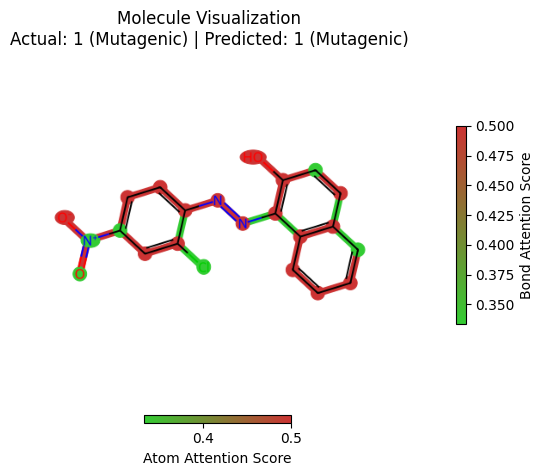

2026-01-30 11:28:10 - PngImagePlugin.py:204 - call - STREAM b'IHDR' 16 13
2026-01-30 11:28:10 - PngImagePlugin.py:204 - call - STREAM b'bKGD' 41 6
2026-01-30 11:28:10 - PngImagePlugin.py:754 - _open - b'bKGD' 41 6 (unknown)
2026-01-30 11:28:10 - PngImagePlugin.py:204 - call - STREAM b'IDAT' 59 8192
2026-01-30 11:28:10 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 28038 402
2026-01-30 11:28:10 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 28452 511
2026-01-30 11:28:10 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 28975 259


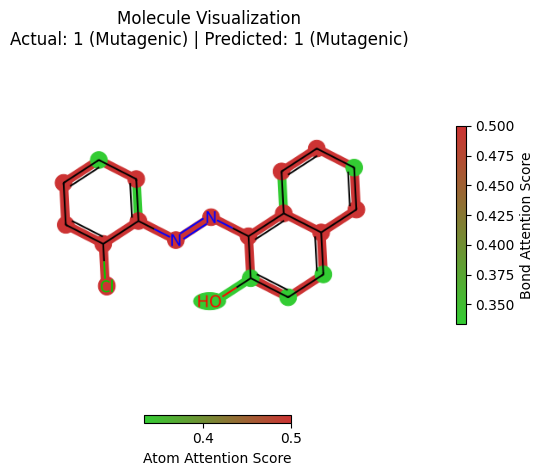

2026-01-30 11:28:11 - PngImagePlugin.py:204 - call - STREAM b'IHDR' 16 13
2026-01-30 11:28:11 - PngImagePlugin.py:204 - call - STREAM b'bKGD' 41 6
2026-01-30 11:28:11 - PngImagePlugin.py:754 - _open - b'bKGD' 41 6 (unknown)
2026-01-30 11:28:11 - PngImagePlugin.py:204 - call - STREAM b'IDAT' 59 8192
2026-01-30 11:28:11 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 29112 442
2026-01-30 11:28:11 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 29566 561
2026-01-30 11:28:11 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 30139 287


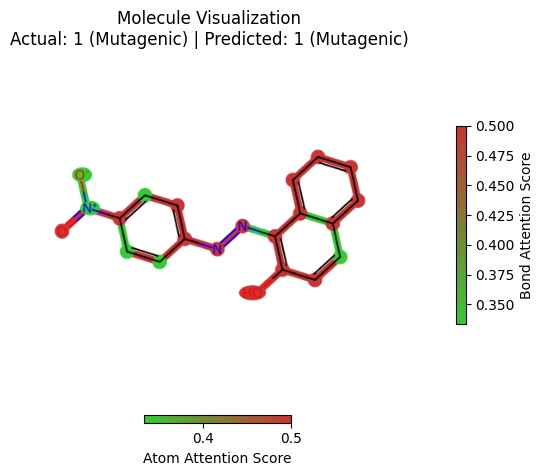

2026-01-30 11:28:12 - PngImagePlugin.py:204 - call - STREAM b'IHDR' 16 13
2026-01-30 11:28:12 - PngImagePlugin.py:204 - call - STREAM b'bKGD' 41 6
2026-01-30 11:28:12 - PngImagePlugin.py:754 - _open - b'bKGD' 41 6 (unknown)
2026-01-30 11:28:12 - PngImagePlugin.py:204 - call - STREAM b'IDAT' 59 8192
2026-01-30 11:28:12 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 27664 384
2026-01-30 11:28:12 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 28060 492
2026-01-30 11:28:12 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 28564 245


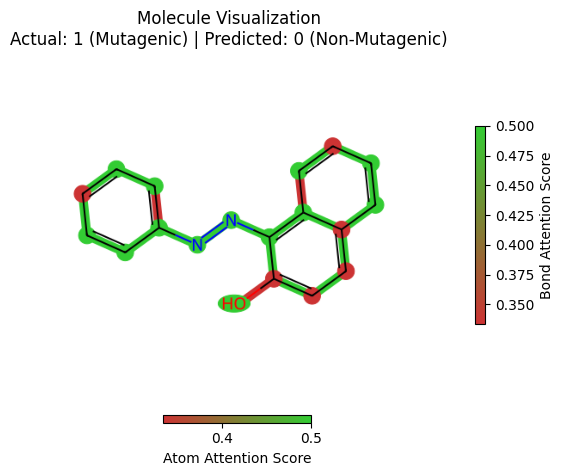

2026-01-30 11:28:12 - PngImagePlugin.py:204 - call - STREAM b'IHDR' 16 13
2026-01-30 11:28:12 - PngImagePlugin.py:204 - call - STREAM b'bKGD' 41 6
2026-01-30 11:28:12 - PngImagePlugin.py:754 - _open - b'bKGD' 41 6 (unknown)
2026-01-30 11:28:12 - PngImagePlugin.py:204 - call - STREAM b'IDAT' 59 8192
2026-01-30 11:28:12 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 34111 429
2026-01-30 11:28:12 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 34552 548
2026-01-30 11:28:12 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 35112 282


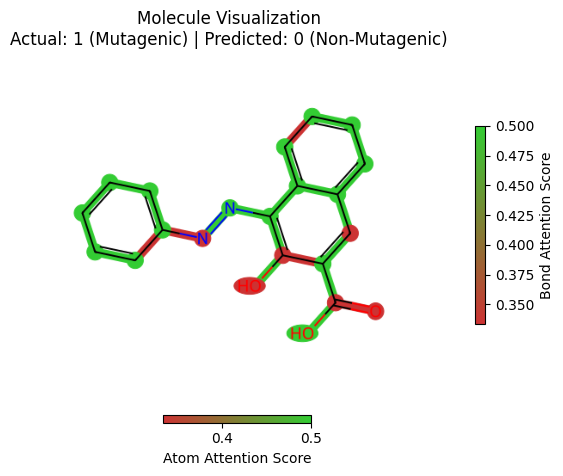

2026-01-30 11:28:13 - PngImagePlugin.py:204 - call - STREAM b'IHDR' 16 13
2026-01-30 11:28:13 - PngImagePlugin.py:204 - call - STREAM b'bKGD' 41 6
2026-01-30 11:28:13 - PngImagePlugin.py:754 - _open - b'bKGD' 41 6 (unknown)
2026-01-30 11:28:13 - PngImagePlugin.py:204 - call - STREAM b'IDAT' 59 8192
2026-01-30 11:28:13 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 38624 489
2026-01-30 11:28:13 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 39125 622
2026-01-30 11:28:13 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 39759 318


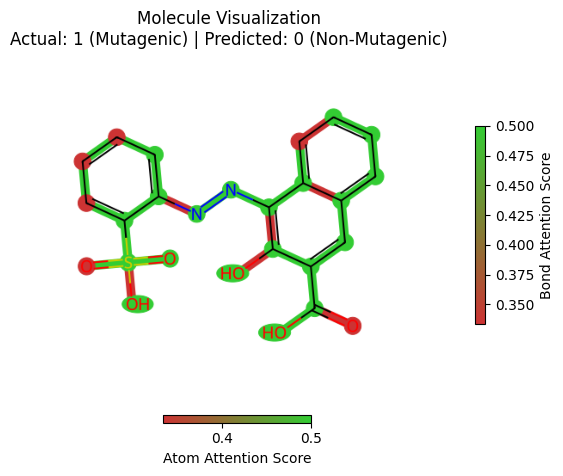

2026-01-30 11:28:14 - PngImagePlugin.py:204 - call - STREAM b'IHDR' 16 13
2026-01-30 11:28:14 - PngImagePlugin.py:204 - call - STREAM b'bKGD' 41 6
2026-01-30 11:28:14 - PngImagePlugin.py:754 - _open - b'bKGD' 41 6 (unknown)
2026-01-30 11:28:14 - PngImagePlugin.py:204 - call - STREAM b'IDAT' 59 8192
2026-01-30 11:28:14 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 33398 509
2026-01-30 11:28:14 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 33919 647
2026-01-30 11:28:14 - PngImagePlugin.py:204 - call - STREAM b'zTXt' 34578 326


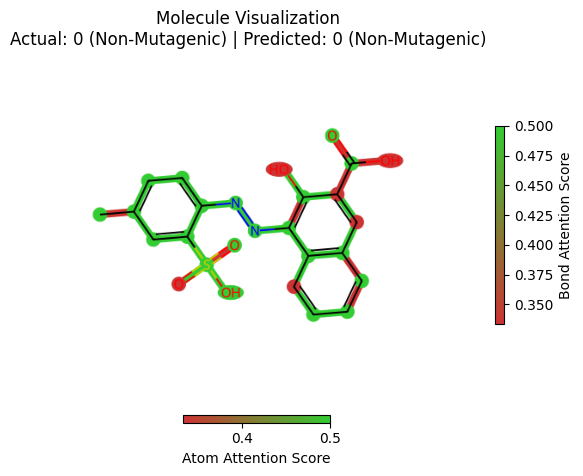

In [16]:
predicted_probs, predicted_labels, attention_scores = process_smiles(
    smiles_list=smiles_list,
    actual_labels=actual_label,  # Make sure this is a list of labels
    model1=model1,
    test_dataloader=test_dataloader,
    visualize_attention=visualize_attention
)

# print("Predicted probabilities:", predicted_probs)
# print("Predicted labels:", predicted_labels)
# print("Attention scores:", attention_scores)